In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
# import data
transactions = pd.read_excel('data/grocery_database.xlsx', sheet_name = 'transactions')
product_areas = pd.read_excel('data/grocery_database.xlsx', sheet_name = 'product_areas')

transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


In [3]:
product_areas.head()

,product_area_id,product_area_name,profit_margin
0,1,Non-Food,0.25
1,2,Vegetables,0.18
2,3,Fruit,0.14
3,4,Dairy,0.19
4,5,Meat,0.11


In [4]:
# merge data
transactions = pd.merge(transactions, product_areas, how = 'inner', on = 'product_area_id')
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14
1,1,2020-07-20,436667313620,3,8,19.99,Fruit,0.14
2,1,2020-07-22,436686191960,3,20,61.69,Fruit,0.14
3,1,2020-08-12,436899350757,3,16,52.28,Fruit,0.14
4,1,2020-08-13,436908803653,3,14,34.58,Fruit,0.14


In [5]:
# inspect product area value counts
transactions['product_area_name'].value_counts()

Fruit         8699
Vegetables    8473
Non-Food      7784
Dairy         7360
Meat          6190
Name: product_area_name, dtype: int64

In [6]:
# drop rows with non-food category
transactions = transactions.drop(transactions[transactions['product_area_name'] == 'Non-Food'].index)
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14
1,1,2020-07-20,436667313620,3,8,19.99,Fruit,0.14
2,1,2020-07-22,436686191960,3,20,61.69,Fruit,0.14
3,1,2020-08-12,436899350757,3,16,52.28,Fruit,0.14
4,1,2020-08-13,436908803653,3,14,34.58,Fruit,0.14


In [7]:
# pivot data to place product areas as columns
transactions_summary_pivot = transactions.pivot_table(
    index = 'customer_id',
    columns = 'product_area_name',
    values = 'sales_cost',
    aggfunc = 'sum',
    fill_value = 0,
    margins = True,
    margins_name = 'Total'
).rename_axis(None, axis = 1)

transactions_summary_pivot.head()

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,367.74,276.00,543.38,167.12,1354.24
2,150.63,120.93,241.21,99.05,611.82
3,46.20,75.39,171.13,31.50,324.22
4,341.91,245.36,272.79,142.35,1002.41
5,694.71,815.32,1405.19,350.10,3265.32


In [8]:
# convert product sales to % of total sales
transactions_summary_pivot = transactions_summary_pivot.div(transactions_summary_pivot['Total'], axis = 0)
transactions_summary_pivot.head()

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1.0
2,0.246200,0.197656,0.394250,0.161894,1.0
3,0.142496,0.232527,0.527821,0.097156,1.0
4,0.341088,0.244770,0.272134,0.142008,1.0
5,0.212754,0.249691,0.430338,0.107218,1.0


In [9]:
# drop total column
data_for_clustering = transactions_summary_pivot.drop(['Total'], axis = 1)
data_for_clustering.head()

,Dairy,Fruit,Meat,Vegetables
customer_id,,,,
1,0.271547,0.203804,0.401244,0.123405
2,0.246200,0.197656,0.394250,0.161894
3,0.142496,0.232527,0.527821,0.097156
4,0.341088,0.244770,0.272134,0.142008
5,0.212754,0.249691,0.430338,0.107218


In [10]:
# check for missing values (options are to drop or use imputer to estimate values)
# no missing values in this scenario
data_for_clustering.isna().sum()

Dairy         0
Fruit         0
Meat          0
Vegetables    0
dtype: int64

In [11]:
# normalize data
scale_norm = MinMaxScaler()
data_for_clustering_scaled = pd.DataFrame(scale_norm.fit_transform(data_for_clustering), columns = data_for_clustering.columns)

data_for_clustering_scaled.head()

,Dairy,Fruit,Meat,Vegetables
0,0.309044,0.250873,0.432358,0.164665
1,0.280196,0.243305,0.424823,0.216022
2,0.162172,0.286229,0.568751,0.129640
3,0.388187,0.301300,0.293237,0.189487
4,0.242132,0.307357,0.463709,0.143065


c:\Users\nick.reyes\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


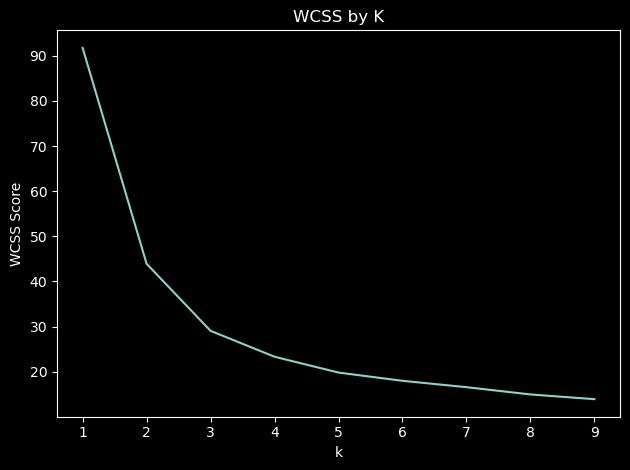

In [12]:
# determine optimal value for k
# based on the plt we will use k = 4
k_values = list(range(1, 10))
wcss_list = []

for k in k_values:
    k_means = KMeans(n_clusters = k)
    k_means.fit(data_for_clustering_scaled)
    wcss_list.append(k_means.inertia_)

plt.plot(k_values, wcss_list)
plt.title('WCSS by K')
plt.xlabel('k')
plt.ylabel('WCSS Score')
plt.tight_layout()
plt.show()

In [13]:
# instantiate and fit model
k_means = KMeans(n_clusters = 4)
k_means.fit(data_for_clustering_scaled)

KMeans(n_clusters=4)

In [14]:
# add cluster labels
data_for_clustering['Cluster'] = k_means.labels_
data_for_clustering.head()

,Dairy,Fruit,Meat,Vegetables,Cluster
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,3
2,0.246200,0.197656,0.394250,0.161894,3
3,0.142496,0.232527,0.527821,0.097156,3
4,0.341088,0.244770,0.272134,0.142008,1
5,0.212754,0.249691,0.430338,0.107218,3


In [15]:
# check cluster sizes
data_for_clustering['Cluster'].value_counts()

1    352
3    303
2    113
0    103
Name: Cluster, dtype: int64

In [16]:
# profile clusters
cluster_summary = data_for_clustering.groupby('Cluster').mean(['Dairy', 'Fruit', 'Vegetables']).reset_index()
cluster_summary

,Cluster,Dairy,Fruit,Meat,Vegetables
0,0,0.002382,0.637796,0.003696,0.356126
1,1,0.220877,0.322205,0.318346,0.138572
2,2,0.375525,0.392697,0.009989,0.221788
3,3,0.223166,0.204219,0.435197,0.137418


The above table shows the percentage spend in each product area by cluster.